In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
import numpy as np

In [ ]:
data = pd.read_csv('/content/weather_data.csv', parse_dates=['date'])
data.set_index('date', inplace=True)

print(data.head())

            temperature
date                   
2014-01-01    10.248357
2014-01-02     9.950428
2014-01-03    10.362958
2014-01-04    10.820167
2014-01-05     9.961091


**Preprocessing and normalizing the data**

In [ ]:
scaler = MinMaxScaler()
data['temperature'] = scaler.fit_transform(data[['temperature']])

temperature_data = data['temperature'].values

# Split into training and testing here train is 80% and test is 20%
train_size = int(len(temperature_data) * 0.8)
train_data, test_data = temperature_data[:train_size], temperature_data[train_size:]

**Creating the sequence**

In [ ]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 30
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

In [ ]:
train_sequences = train_sequences.reshape(-1, sequence_length, 1)
test_sequences = test_sequences.reshape(-1, sequence_length, 1)

**Building the LSTM Model**

In [ ]:
input = train_sequences.shape[1]  # sequence length
features = train_sequences.shape[2]

**Defining the Autoencoder model**

In [ ]:
# Define the Autoencoder model
inputs = Input(shape=(input, features))

# Encoder
encoded = LSTM(128, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(64, activation='relu', return_sequences=False)(encoded)
latent = Dense(32, activation='relu')(encoded)  # Dense layer for latent space
latent_repeated = RepeatVector(input)(latent)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(latent_repeated)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
output = TimeDistributed(Dense(1))(decoded)

In [ ]:
autoencoder = Model(inputs, output)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,825 (944.63 KB)

 Trainable params: 241,825 (944.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(train_sequences, train_sequences, epochs=50, batch_size=32, validation_split=0.1,shuffle=True)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - loss: 0.1476 - val_loss: 0.0215
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - loss: 0.0179 - val_loss: 0.0082
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/

**Evaluating the reconstructed error on the test data**

In [ ]:
reconstructed_sequences = autoencoder.predict(test_sequences)
reconstruction_error = np.mean(np.abs(reconstructed_sequences - test_sequences), axis=(1, 2))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


In [ ]:
print(reconstruction_error)

[0.02654336 0.02586378 0.02570156 0.0263128  0.02737298 0.0275918
 0.02562043 0.0244387  0.02627327 0.02910139 0.02878802 0.02971195
 0.0295864  0.02806762 0.02756502 0.02916734 0.02798005 0.0277499
 0.02799226 0.0292581  0.03045627 0.03042937 0.02949074 0.03136913
 0.0319277  0.03183334 0.03076586 0.03013434 0.03073007 0.03088105
 0.03341803 0.03547095 0.03570749 0.0339844  0.03449505 0.03470341
 0.03428251 0.03191402 0.0306152  0.02916922 0.0290991  0.02867593
 0.02831038 0.02952028 0.03252427 0.03120742 0.03428234 0.03496773
 0.03341628 0.03320396 0.03193354 0.03225524 0.03210103 0.03288249
 0.0326788  0.03177464 0.03046389 0.03075379 0.03116748 0.02831598
 0.02918788 0.02631635 0.02694649 0.0263589  0.02875356 0.02970265
 0.03041847 0.03047745 0.02942998 0.02889165 0.02691572 0.02822017
 0.02990897 0.0298489  0.02636058 0.02806514 0.02481824 0.02539696
 0.0247987  0.02479107 0.02688083 0.0268815  0.02620983 0.02580223
 0.02756385 0.02770718 0.02883419 0.02904134 0.02837334 0.028334

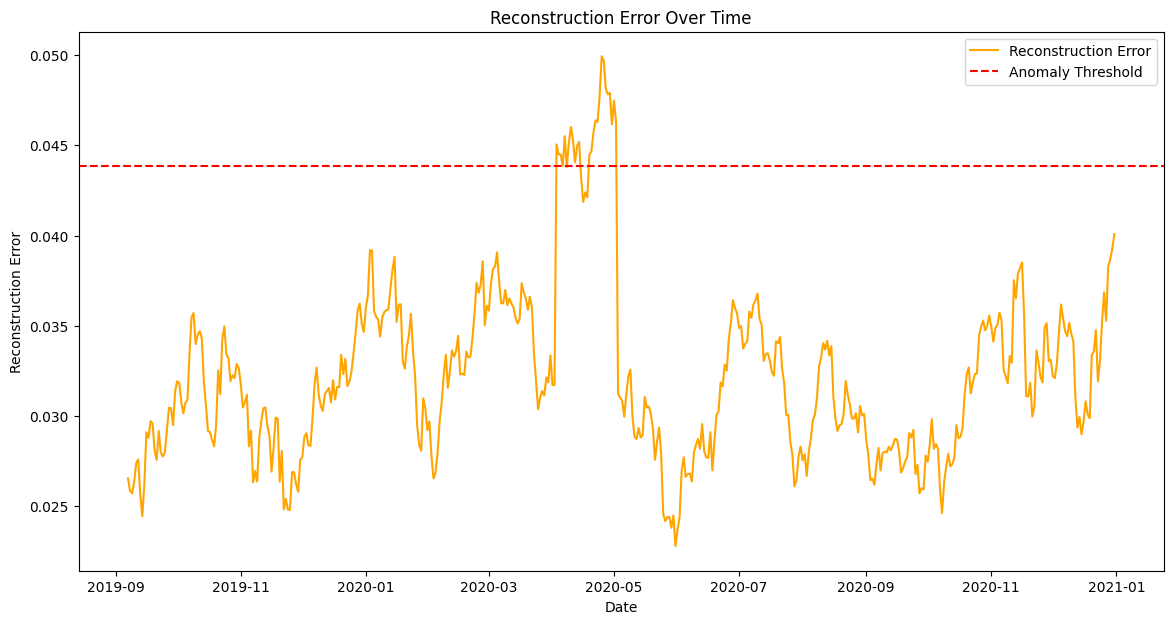

In [ ]:
# Plotting Reconstruction Error
plt.figure(figsize=(14, 7))
plt.plot(test_dates, reconstruction_error, label='Reconstruction Error', color='orange')
plt.axhline(y=threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


The graph illustrates the reconstruction error over time and highlights the points where the error surpasses the defined anomaly threshold, indicating potential anomalies in the temperature data. Significant spikes in the reconstruction error occur at certain dates, signaling that the temperature readings for those days deviated from the expected pattern. Specifically, the threshold is crossed **around March 2020**, where there is a notable increase in the reconstruction error, suggesting an unusual temperature event. Additionally, another significant anomaly is observed towards the **end of 2020**, where the error exceeds the threshold once again.

**Defining the Threshold for anomaly**

In [ ]:
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly detection threshold: {threshold}")

Anomaly detection threshold: 0.04386938399752767


**Identifing the anomalies**

In [ ]:
anomalies = reconstruction_error > threshold

# Ensuring that  test_dates matches the length of reconstruction_error so that it won't be mismatching with the dataframe
test_dates = test_dates[:len(reconstruction_error)]

# Creating a DataFrame for anomalies
anomalies_df = pd.DataFrame({
    'Date': test_dates,
    'Reconstruction_Error': reconstruction_error,
    'Anomaly': anomalies
})

**Visualizing the Anomalies**

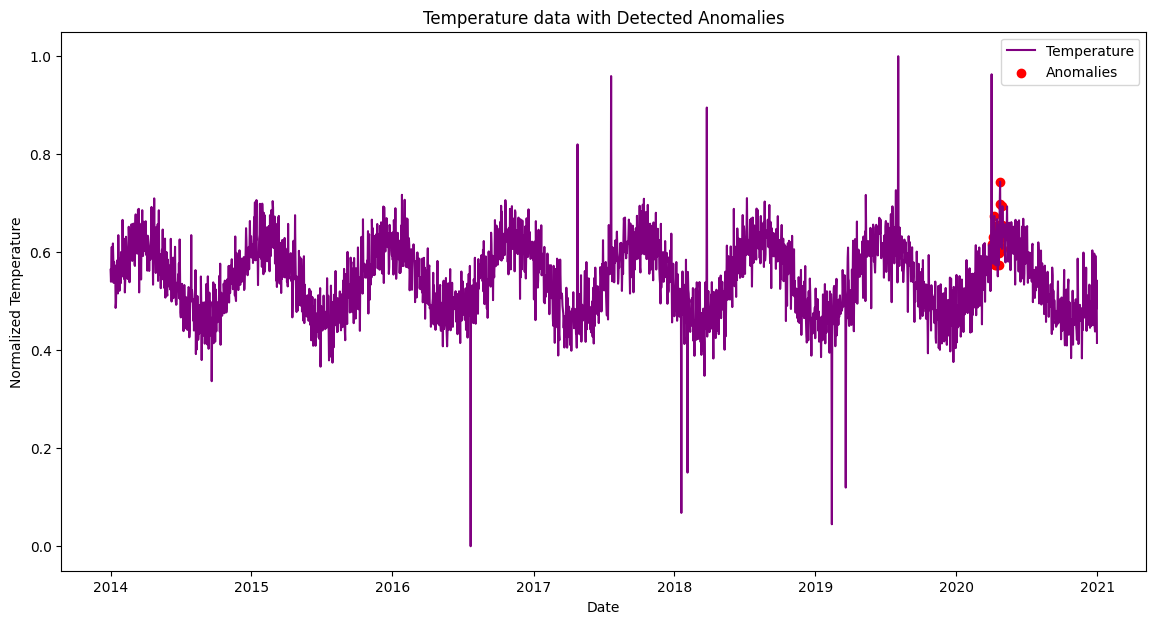

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['temperature'], label='Temperature', color='purple')

# Highlighting anomalies
anomaly_dates = anomalies_df[anomalies_df['Anomaly']]['Date']
plt.scatter(anomaly_dates, data.loc[anomaly_dates, 'temperature'], color='red', label='Anomalies')

plt.title('Temperature data with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Normalized Temperature')
plt.legend()
plt.show()


**Interpretation**

The plot shows temperature changes over the years, with the green line representing the normal seasonal patterns. The red dots highlight unusual days when the temperature was significantly different from what’s expected, either much higher or lower. These unusual points could indicate extreme weather events, like heatwaves or cold spells, or possible errors in the data. Most of the temperatures follow the normal trend, but the red dots stand out as anomalies that need further investigation to understand what caused them.